In [1]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import cv2
import json
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass

from calib_utils import *

DATA_ROOT = Path("../../data")

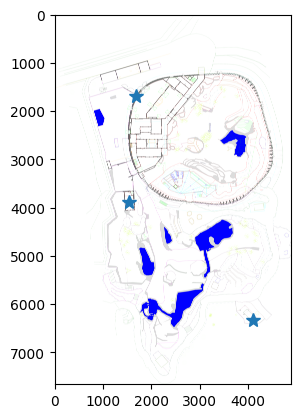

In [2]:
# Map to world constraints
@dataclass
class WorldMapConstraints:
    world2_points: np.ndarray
    map_points: np.ndarray


map_constraints = WorldMapConstraints(
    world2_points=np.array([(-73.29, 55.69), (-77.21, -6.51), (-4.88, -75.34)]),
    map_points=np.array([(1682, 1683), (1543, 3886), (4106, 6327)]),
)

# Flip y becuase users are used to this in campos.ch
flip_y = np.array([[1, 0], [0, -1]])
map_constraints.world2_points = (flip_y @ map_constraints.world2_points.T).T

map_file = "kkep_floorplan.png"
im_map = imread_rgb(DATA_ROOT / map_file)
plt.imshow(im_map)
plt.plot(
    map_constraints.map_points[:, 0],
    map_constraints.map_points[:, 1],
    "*",
    markersize=10,
)

In [3]:
# Map to world calibration
from optimization_helpers import optimizeModel, IModelEvaluator


class Similarity2DEvaluator(IModelEvaluator[np.ndarray]):
    def __init__(self, points_a: np.ndarray, points_b: np.ndarray):
        super().__init__()
        count, _ = points_a.shape
        assert points_a.shape == (count, 2)
        assert points_a.shape == points_b.shape

        self.points_a = points_a
        self.points_b = points_b

    def model2params(self, model: np.ndarray) -> np.ndarray:
        return np.array([model[0, 0], model[1, 1], model[0, 2], model[1, 2]])

    def params2model(self, params: np.ndarray) -> np.ndarray:
        return np.array(
            [[params[0], 0, params[2]], [0, params[1], params[3]], [0, 0, 1]]
        )

    def getParamBounds(self) -> None:
        return None

    def evaluateModel(self, model: np.ndarray) -> float:
        points_aa = hmult(model, self.points_b)
        cost = np.sum(np.linalg.norm(points_aa - self.points_a, axis=1))
        return cost


evaluator = Similarity2DEvaluator(
    map_constraints.map_points, map_constraints.world2_points
)
m0 = np.array([[1, 0, 0], [0, 1, 0]])
display(evaluator.evaluateModel(m0))
T_map_from_world2 = optimizeModel(evaluator, m0, debug=True)
display("")
print(f"Final error in pixels: {evaluator.evaluateModel(T_map_from_world2)}")
print(f"{T_map_from_world2=}")
T_world2_from_map = np.linalg.inv(T_map_from_world2)
print(f"{T_world2_from_map=}")

np.float64(14116.734617293754)

         Current function value: 1.512272
         Iterations: 91
         Function evaluations: 932
         Gradient evaluations: 184
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.5122720031271482
        x: [ 3.543e+01  3.544e+01  4.279e+03  3.657e+03]
      nit: 91
      jac: [-3.897e+00  6.477e+01 -2.943e-01  1.859e-01]
 hess_inv: [[ 5.176e-09  2.098e-09  1.876e-07 -1.788e-07]
            [ 2.098e-09  1.632e-09  1.025e-07 -1.093e-07]
            [ 1.876e-07  1.025e-07  8.135e-06 -7.945e-06]
            [-1.788e-07 -1.093e-07 -7.945e-06  8.534e-06]]
     nfev: 932
     njev: 184
Optimization cost: start=14116.734617293754, delta=-14115.222345290627


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error in pixels: 1.5122720031271482
T_map_from_world2=array([[3.54334161e+01, 0.00000000e+00, 4.27891507e+03],
       [0.00000000e+00, 3.54422651e+01, 3.65677974e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
T_world2_from_map=array([[ 2.82219472e-02,  0.00000000e+00, -1.20759315e+02],
       [ 0.00000000e+00,  2.82149009e-02, -1.03175678e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


In [4]:
# Load config

config_file = Path(DATA_ROOT / "config.json")
try:
    with config_file.open() as f:
        config = json.load(f)
except:
    config = {}

# Save map
config["map"] = {}
config["map"]["image"] = str(map_file)
config["map"]["T_map_from_world2"] = T_map_from_world2.tolist()

config_json = json.dumps(config, indent=2)
print(config_json)

with config_file.open("w") as f:
    f.write(config_json)

{
  "map": {
    "image": "kkep_floorplan.png",
    "T_map_from_world2": [
      [
        35.43341611079362,
        0.0,
        4278.915067350808
      ],
      [
        0.0,
        35.44226513454969,
        3656.779744620961
      ],
      [
        0.0,
        0.0,
        1.0
      ]
    ]
  },
  "models2": {
    "elephant_label_id": 1,
    "segmentation": "../models/maskrcnn_trained.ptc"
  },
  "models": {
    "elephant_label_id": 22,
    "segmentation": "../models/camera0/segmentation/torch.pt"
  },
  "cameras": {
    "zag_elp_cam_017": {
      "sample_image": "cameras/zag_elp_cam_017/ZAG-ELP-CAM-017_sample.jpg",
      "intrinsics": {
        "width": 2688,
        "height": 1520,
        "K": [
          [
            978.3519897075522,
            0.0,
            1344.0
          ],
          [
            0.0,
            978.3519897075522,
            760.0
          ],
          [
            0.0,
            0.0,
            1.0
          ]
        ],
        "distor